# Wide-field imaging demonstration

This script makes a fake data set, fills it with a number of point components, and then images it using a variety of algorithms. See imaging-fits for a similar notebook that checks for errors in the recovered properties of the images.

The measurement equation for a wide field of view interferometer is:

$$V(u,v,w) =\int \frac{I(l,m)}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um + w(\sqrt{1-l^2-m^2}-1))} dl dm$$

We will show various algorithms for computing approximations to this integral. Calculation of the visibility $V$ from the sky brightness $I$ is called {\bf predict}, and the inverese is called {\bf invert}.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.data.polarisation import Polarisation_Frame
from arl.visibility.operations import create_visibility, create_visibility, \
    create_visibility_from_rows, create_visibility_from_rows
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter, vis_wslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import invert_2d, create_image_from_visibility, \
    weight_visibility, predict_skycomponent_visibility, create_w_term_image, invert_facets, \
    invert_timeslice, invert_wslice, invert_wprojection

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

doplot = True

Construct the SKA1-LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. 

This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(lowcore, times, frequency, weight=1.0, phasecentre=phasecentre,
                      polarisation_frame=Polarisation_Frame("stokesI"))

create_visibility: 95865 rows, 0.010 GB


Plot the synthesized UV coverage.

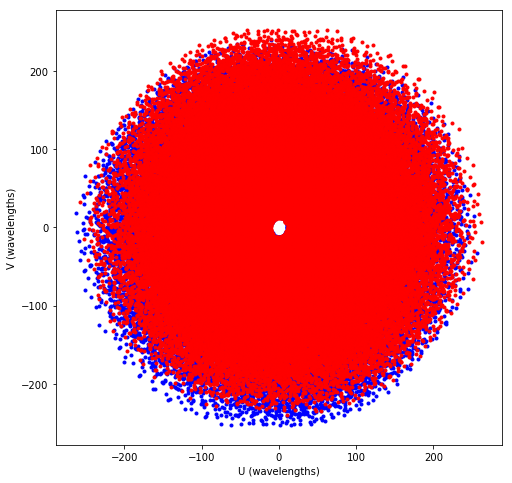

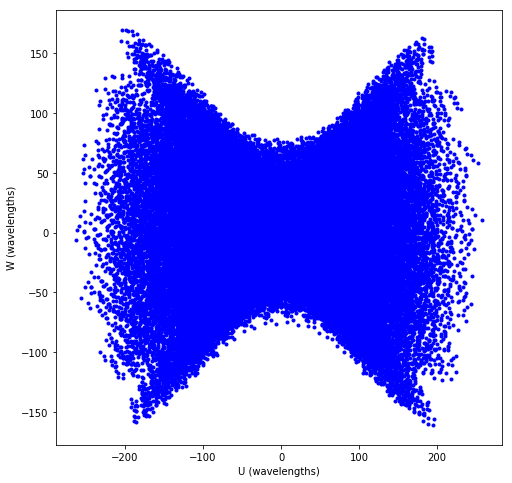

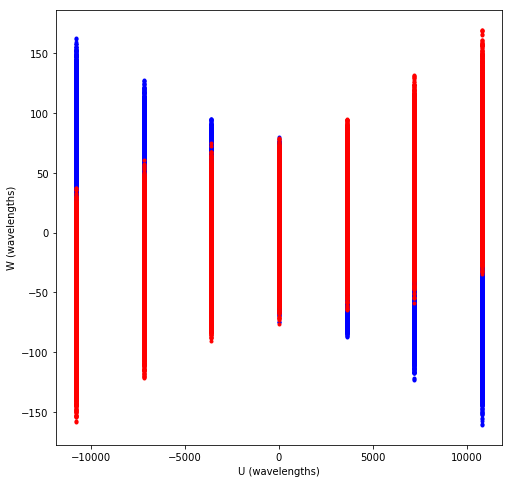

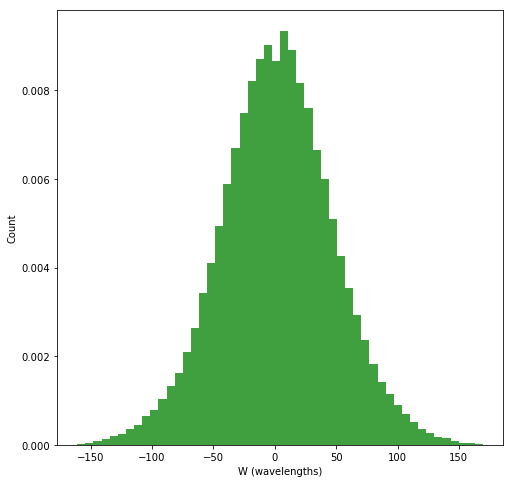

In [4]:
if doplot:
    plt.clf()
    plt.plot(vt.data['uvw'][:, 0], vt.data['uvw'][:, 1], '.', color='b')
    plt.plot(-vt.data['uvw'][:, 0], -vt.data['uvw'][:, 1], '.', color='r')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('V (wavelengths)')
    plt.show()
    
    plt.clf()
    plt.plot(vt.data['uvw'][:, 0], vt.data['uvw'][:, 2], '.', color='b')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('W (wavelengths)')
    plt.show()

    plt.clf()
    plt.plot(vt.data['time'][vt.u>0.0], vt.data['uvw'][:, 2][vt.u>0.0], '.', color='b')
    plt.plot(vt.data['time'][vt.u<=0.0], vt.data['uvw'][:, 2][vt.u<=0.0], '.', color='r')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('W (wavelengths)')
    plt.show()

    plt.clf()
    n, bins, patches = plt.hist(vt.w, 50, normed=1, facecolor='green', alpha=0.75)
    plt.xlabel('W (wavelengths)')
    plt.ylabel('Count')
    plt.show()

Create a grid of components and predict each in turn, using the full phase term including w.

In [5]:
params = {'npixel': 512,
          'cellsize': 0.001,
          'spectral_mode': 'channel',
          'channel_bandwidth': 5e7,
          'reffrequency': 1e8,
          'kernel':'calculated',
          'facets':4}

npixel = 512
cellsize=0.001
facets = 4
flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
spacing_pixels = npixel // facets
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
for iy in centers:
    for ix in centers:
        pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
        pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                   polarisation_frame=Polarisation_Frame("stokesI"))
        predict_skycomponent_visibility(vt, comp)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 128
Component at (63.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 34.4144013, -54.71664839)>
Component at (191.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 21.55800518, -55.91819473)>
Component at (319.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 8.44199482, -55.91819473)>
Component at (447.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    ( 355.5855987, -54.71664839)>
Component at (63.000000, 191.000000) <SkyCoord (ICRS): (ra, dec) in deg

Make the dirty image and point spread function using the two-dimensional approximation:

$$V(u,v,w) =\int I(l,m) e^{2 \pi j (ul+um)} dl dm$$

Note that the shape of the sources vary with position in the image. This space-variant property of the PSF arises from the w-term neglected in the two-dimensional invert.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
weight_gridding: Performing uniform weighting
invert_2d: inverting using 2d transform
Max, min in dirty image = 55.473041, -10.646196, sumwt = 0.164550


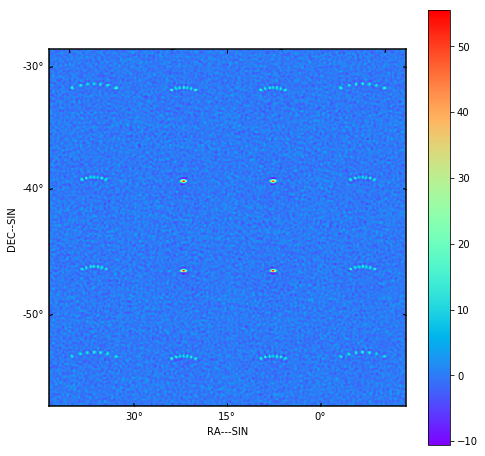

In [6]:
dirty = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
vt, _, _ = weight_visibility(vt, dirty)
dirty, sumwt = invert_2d(vt, dirty)
dirty.data = dirty.data / sumwt
if doplot:
    show_image(dirty)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

export_image_to_fits(dirty, 'imaging-wterm_dirty.fits')

This occurs because the Fourier transform relationship between sky brightness and visibility is only accurate over small fields of view. 

Hence we can make an accurate image by partitioning the image plane into small regions, treating each separately and then glueing the resulting partitions into one image. We call this image plane partitioning image plane faceting.

$$V(u,v,w) = \sum_{i,j} \frac{1}{\sqrt{1- l_{i,j}^2- m_{i,j}^2}} e^{-2 \pi j (ul_{i,j}+um_{i,j} + w(\sqrt{1-l_{i,j}^2-m_{i,j}^2}-1))}
\int  I(\Delta l, \Delta m) e^{-2 \pi j (u\Delta l_{i,j}+u \Delta m_{i,j})} dl dm$$


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_facets: Inverting by image facets
invert_with_image_iterator: Inverting by image partitions
raster: predicting using 4 x 4 image partitions
raster: spacing of raster (128, 128)
raster: partition (0, 0) of (4, 4)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 34.4144013, -54.71664839)>
raster: partition (1, 0) of (4, 4)
shift_vis_from_image: shifting phasecentre from vis phas

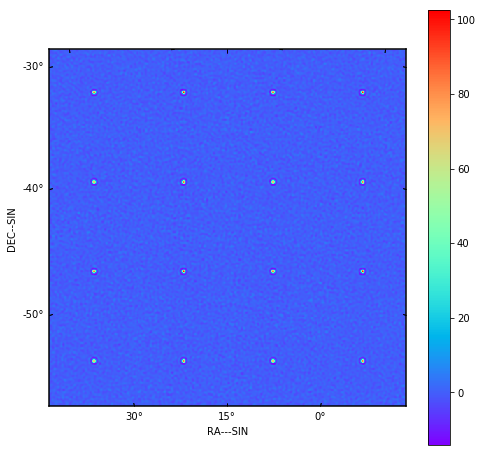

In [7]:
dirtyFacet = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
dirtyFacet, sumwt = invert_facets(vt, dirtyFacet, facets=4)
dirtyFacet.data = dirtyFacet.data / sumwt

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), sumwt))
export_image_to_fits(dirtyFacet, 'imaging-wterm_dirtyFacet.fits')

That was the best case. This time, we will not arrange for the partitions to be centred on the sources. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_facets: Inverting by image facets
invert_with_image_iterator: Inverting by image partitions
raster: predicting using 2 x 2 image partitions
raster: spacing of raster (256, 256)
raster: partition (0, 0) of (2, 2)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    ( 26.94754342, -51.80721107)>
raster: partition (1, 0) of (2, 2)
shift_vis_from_image: shifting phasecentre from vis pha

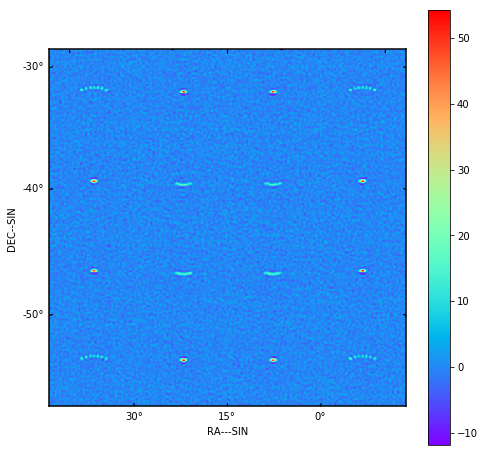

In [8]:
dirtyFacet2 = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
dirtyFacet2, sumwt = invert_facets(vt, dirtyFacet2, facets=2)
dirtyFacet2.data = dirtyFacet2.data / sumwt

if doplot:
    show_image(dirtyFacet2)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet2.data.max(), dirtyFacet2.data.min(), sumwt))
export_image_to_fits(dirtyFacet2, 'imaging-wterm_dirtyFacet2.fits')

Another approach is to partition the visibility data by slices in w. The measurement equation is approximated as:

$$V(u,v,w) =\sum_i \int   \frac{ I(l,m) e^{-2 \pi j (w_i(\sqrt{1-l^2-m^2}-1))})}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um)} dl dm$$

If images constructed from slices in w are added after applying a w-dependent image plane correction, the w term will be corrected. 

The w-dependent w-beam is:

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
create_w_term_image: For w = 169.6, field of view = 0.512000, Fresnel number = 11.12


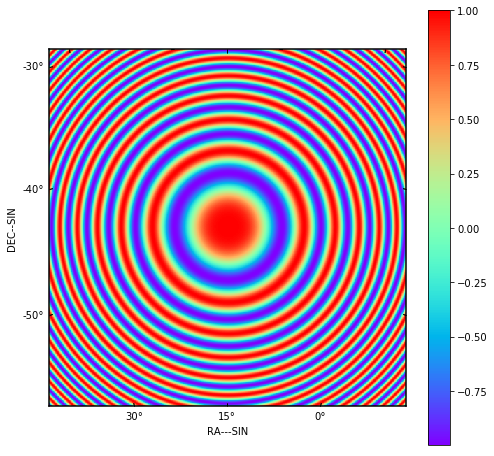

In [9]:
if doplot:
    wterm = create_w_term_image(vt, npixel=512, cellsize=0.001, npol=1, w=numpy.max(vt.w))
    show_image(wterm)
    plt.show()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_wslice: inverting using w slices
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -157.7, field of view = 0.512000, Fresnel number = 10.34
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -149.3, field of view = 0.512000, Fresnel number = 9.79
invert_2d_base: retaining imaginary part of dirty image
create_w_term_image: For w = -139.7, field of view = 0.512000, Fresnel number = 9.15
invert_2d_base: retaining imaginary part of dirty im

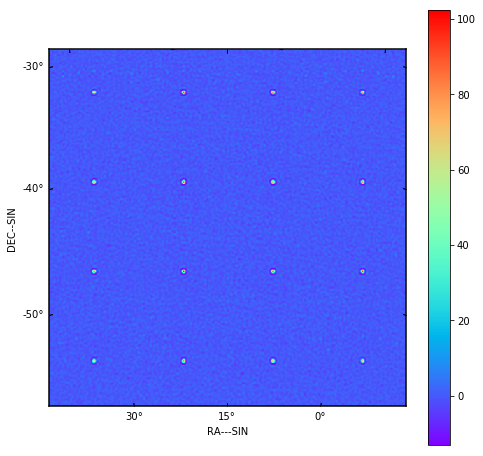

Max, min in dirty image = 102.287421, -13.204737, sumwt = 0.164960


In [10]:
dirtyWslice = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
dirtyWslice, sumwt= invert_wslice(vt, dirtyWslice, wslice=10.0, padding=2, nprocessor=1, 
                                        compression_factor=0.0)

dirtyWslice.data /= sumwt
show_image(dirtyWslice)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtyWslice.data.max(), dirtyWslice.data.min(), sumwt))

export_image_to_fits(dirtyWslice, 'imaging-wterm_dirty_Wslice.fits')

The w-term can also be viewed as a time-variable distortion. Approximating the array as instantaneously co-planar, we have that w can be expressed in terms of $u,v$

$$w = a u + b v$$

Transforming to a new coordinate system:

$$ l' = l + a (\sqrt{1-l^2-m^2}-1))$$
$$ m' = m + b (\sqrt{1-l^2-m^2}-1))$$

Ignoring changes in the normalisation term, we have:

$$V(u,v,w) =\int \frac{I(l',m')}{\sqrt{1-l'^2-m'^2}} e^{-2 \pi j (ul'+um')} dl' dm'$$

To illustrate this, we will construct images as a function of time. For comparison, we show difference of each time slice from the best facet image. Instantaneously the sources are un-distorted but do lie in the wrong location.

vis_timeslice_iter: Found 7 unique times
vis_timeslice_auto: Guessing time interval to be 3600.00 s
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 193.050761 wavelengths
create_image_from_visibility: Critical cellsize = 0.002590 radians, 0.148396 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Max, min in dirty image = 97.698800, -19.833411, sumwt = 0.023253


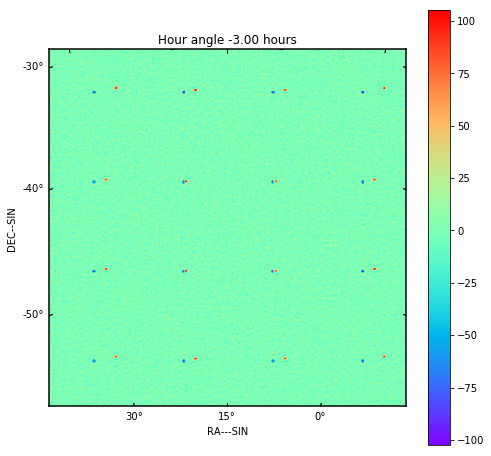

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 231.734708 wavelengths
create_image_from_visibility: Critical cellsize = 0.002158 radians, 0.123624 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Max, min in dirty image = 104.632093, -19.891477, sumwt = 0.023726


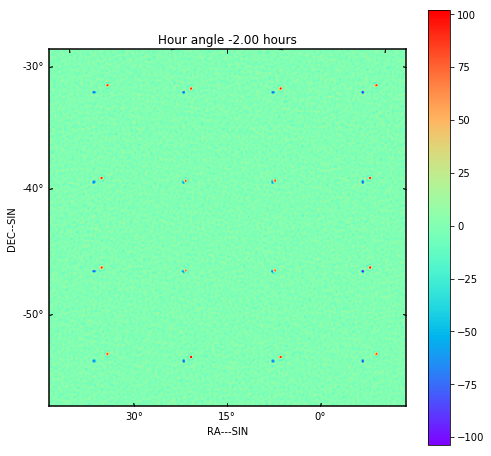

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 255.904441 wavelengths
create_image_from_visibility: Critical cellsize = 0.001954 radians, 0.111948 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Max, min in dirty image = 102.772008, -18.679268, sumwt = 0.023654


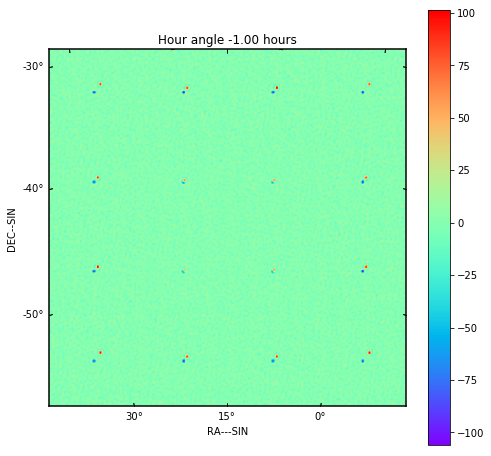

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Max, min in dirty image = 102.972644, -20.607442, sumwt = 0.023944


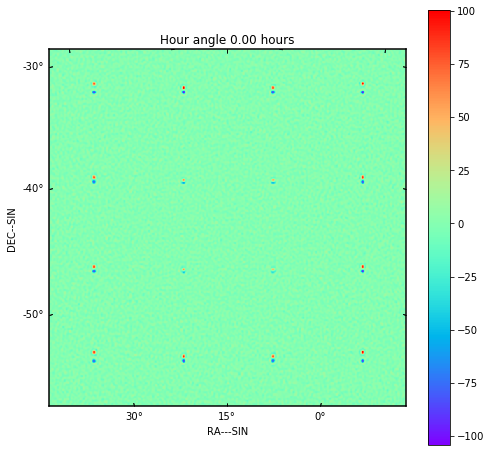

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 253.641975 wavelengths
create_image_from_visibility: Critical cellsize = 0.001971 radians, 0.112946 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Max, min in dirty image = 100.828155, -18.951750, sumwt = 0.023362


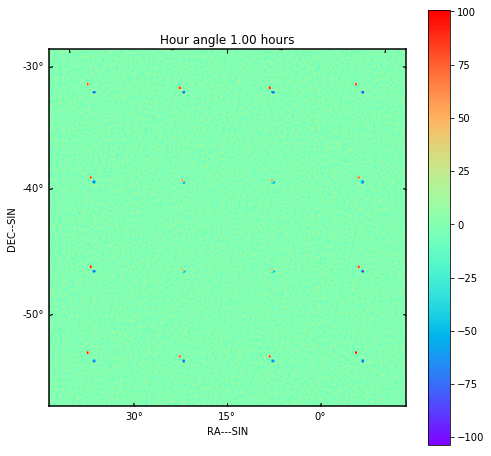

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 236.737485 wavelengths
create_image_from_visibility: Critical cellsize = 0.002112 radians, 0.121011 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Max, min in dirty image = 102.935430, -19.107284, sumwt = 0.023661


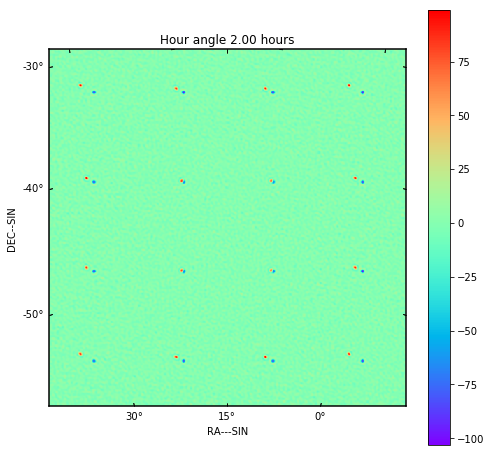

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 204.646182 wavelengths
create_image_from_visibility: Critical cellsize = 0.002443 radians, 0.139987 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using 2d transform
Max, min in dirty image = 100.696965, -19.559242, sumwt = 0.022951


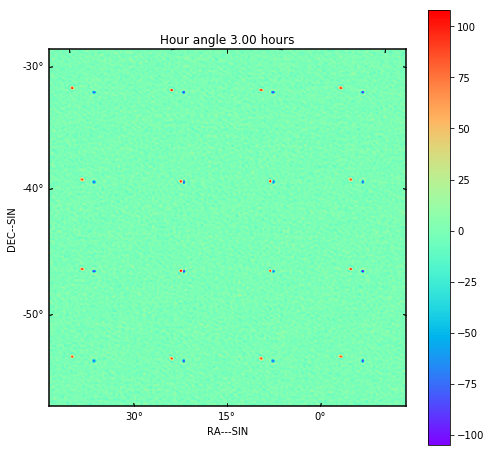

In [11]:
for rows in vis_timeslice_iter(vt):
    visslice = create_visibility_from_rows(vt, rows)
    dirtySnapshot = create_image_from_visibility(visslice, npixel=512, cellsize=0.001, npol=1, compress_factor=0.0)
    dirtySnapshot, sumwt = invert_2d(visslice, dirtySnapshot)

    dirtySnapshot.data /= sumwt

    print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
          (dirtySnapshot.data.max(), dirtySnapshot.data.min(), sumwt))
    if doplot:
        dirtySnapshot.data -= dirtyFacet.data
        show_image(dirtySnapshot)
        plt.title("Hour angle %.2f hours" % (numpy.average(visslice.time) * 12.0 / 43200.0))
        plt.show()

This timeslice imaging leads to a straightforward algorithm in which we correct each time slice and then sum the resulting timeslices. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_timeslice: inverting using time slices
predict_timeslice: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
invert_2d: inverting using 2d transform
Time=-10800.000000, p=0.826, q=-0.169
predict_timeslice: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
invert_2d: inverting using 2d transform
Time=-7200.000000, p=0.517, q=-0.265
predict_timeslice: Fit to 13695 rows reduces rms w from 33.7 to 0.0 m
invert_2d: inverting using 2d transform
Time=-3600.000000, p=0.249, q=-0.315
predict_timeslice: Fit to 13

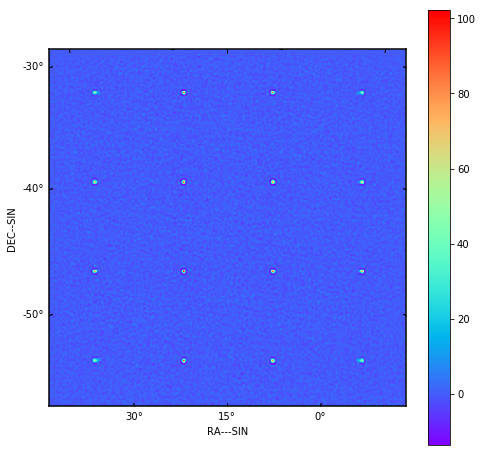

Max, min in dirty image = 102.092180, -13.625111, sumwt = 0.164550


In [12]:
dirtyTimeslice = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
dirtyTimeslice, sumwt= invert_timeslice(vt, dirtyTimeslice, timeslice=1.0, padding=2, nprocessor=1, 
                                        compression_factor=0.0)

dirtyTimeslice.data /= sumwt
show_image(dirtyTimeslice)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtyTimeslice.data.max(), dirtyTimeslice.data.min(), sumwt))

export_image_to_fits(dirtyTimeslice, 'imaging-wterm_dirty_Timeslice.fits')

Finally we try w-projection. For a fixed w, the measurement equation can be stated as as a convolution in Fourier space. 

$$V(u,v,w) =G_w(u,v) \ast \int \frac{I(l,m)}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um)} dl dm$$

where the convolution function is:

$$G_w(u,v) = \int \frac{1}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um + w(\sqrt{1-l^2-m^2}-1))} dl dm$$


Hence when gridding, we can use the transform of the w beam to correct this effect while gridding. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_2d: inverting using wprojection
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 262.144000
get_kernel_list: Recommended wstep = 0.060713
get_kernel_list: Using w projection with wstep = 10.000000
get_kernel_list: Maximum w kernel full width = 16 pixels
w_kernel_list: Maximum w = 169.6 , step is 10.0 wavelengths
Max, min in dirty image = 84.028625, -11.757061, sumwt = 0.034113


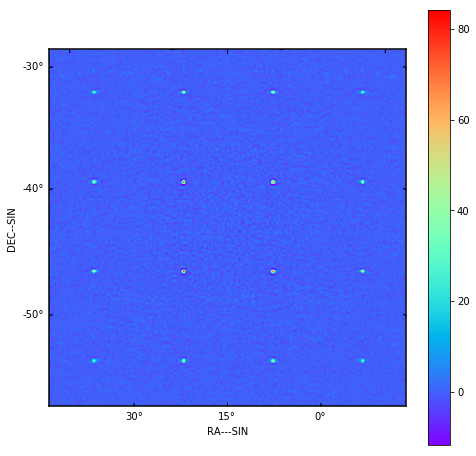

In [13]:
dirtyWProjection = create_image_from_visibility(vt, npixel=512, cellsize=0.001, npol=1)
dirtyWProjection, sumwt = invert_wprojection(vt, dirtyWProjection, wstep=10.0, kernelwidth=16, padding=2,
                                            oversampling=4)
dirtyWProjection.data = dirtyWProjection.data / sumwt

if doplot:
    show_image(dirtyWProjection)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyWProjection.data.max(), 
                                                             dirtyWProjection.data.min(), sumwt))
export_image_to_fits(dirtyWProjection, 'imaging-wterm_dirty_WProjection.fits')